In [1]:
import os
from mat_utils import load_file, parse_math
from utils import select_filenames_by_key_word, select_filenames_by_key_word_neg
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from copy import copy

In [2]:
original_seq_path = "/home/bolci/Documents/Projekty/5G_OPEN_RAN/Anomaly_detection/5G_Open_RAN/Data/rxGridSSBurstIdeal.mat"
data_path = "/home/bolci/Documents/Projekty/5G_OPEN_RAN/Anomaly_detection/5G_Open_RAN/Data/Data_raw"

In [3]:
def mean_by_quaters(array_to_mean):
    new_arr = []
    for x in (range(array_to_mean.shape[1]//4)):
        new_arr.append(array_to_mean[:, 4*x:(4*(x+1))])
    
    new_arr = np.mean(np.array(new_arr), axis=0)

    return new_arr
    

In [4]:
mat_file = load_file(original_seq_path)
pss_sss_raw = mat_file['rxGridSSBurst']
pss_sss_raw = mean_by_quaters(pss_sss_raw)

In [5]:
all_folders = os.listdir(data_path)
all_folders = [x for x in all_folders if not x ==  '.ipynb_checkpoints']

folder_train = ['comeretial']
folder_valid_true = ['Fake_Bts_PCI_466']
folder_valid_false = ['Fake_Bts_PCI_466_wPA']

folders_test_false = ["Fake_Bts_PCI_466_wPA_traffic", "Fake_Bts_PCI_12_wPA"]
folders_test_true = ["Fake_Bts_PCI_12", "Fake_Bts_PCI_466_traffic"]

processed_path = "/home/bolci/Documents/Projekty/5G_OPEN_RAN/Anomaly_detection/5G_Open_RAN/Data_abs_only/Data_channels/"

In [6]:
def repeat_fiels(original_seq, final_seq_shape):
    repeated_seq = np.repeat(original_seq, final_seq_shape[1]//original_seq.shape[1], axis=1)
    if not repeated_seq.shape[1] == final_seq_shape[1]:
        repeated_seq = np.concatenate((repeated_seq, original_seq[:,:2]), axis=1)
    
    return repeated_seq
def to_log(values: np.array) -> np.array:
    return -20 * np.log10(values)

def estimate_channels(signal, original_sequence):
    
    new_seq = np.array([])
    multiply = signal.shape[1]//4

    for x in range(multiply):
        if len(new_seq) == 0:
            new_seq = original_sequence
        else:
            new_seq = np.concatenate((new_seq, original_sequence), axis=1)

    if not signal.shape[1]%4 == 0:
        new_seq = np.concatenate((new_seq, original_sequence[:,:2]), axis=1)

    return signal/new_seq

def complex_to_arr(array):    
    real = array.real
    imag = array.imag

    ret_arr = []

    for real_sl, imag_sl in zip(real, imag):
        new_rr = np.concatenate((real_sl.reshape((-1,1)), imag_sl.reshape((-1,1))), axis=1)
        ret_arr.append(new_rr)
        
    return np.array(ret_arr)

def reshape_arr(arr, no_signals_in_arr = 2):
    
    all_signals = []
    for x in range(arr.shape[1]//no_signals_in_arr):
        single_signal = arr[:, (x*no_signals_in_arr):(x+1)*no_signals_in_arr]

        #single_signal_rs2 = np.concatenate((single_signal[:,0], single_signal[:,1]), axis=0).reshape((-1,1))
        single_signal_res = np.reshape(single_signal, (-1, 1), order='F')
        all_signals.append(single_signal_res)
    
    return np.asarray(all_signals)
    

def process_data_in_folder(folder_name, type):
    source_path = os.path.join(data_path, folder_name)
    all_files = os.listdir(source_path)

    saving_path = os.path.join(processed_path, type, folder_name)
    if not os.path.exists(saving_path):
        os.makedirs(saving_path)

    counter = 0
    
    for signle_file_name in all_files:
        full_path_file = os.path.join(source_path, signle_file_name)
        file_loaded = np.load(full_path_file)
        
        channel_estimation = estimate_channels(file_loaded, pss_sss_raw)

        #channel_estimation_reshaped = channel_estimation.reshape((channel_estimation.shape[0]*2, channel_estimation.shape[1]//2))
        channel_estimation_reshaped = reshape_arr(channel_estimation, no_signals_in_arr=1)    

        ab = np.abs(channel_estimation_reshaped)
        array_channel_estimation = to_log(ab)
        
        #print(channel_estimation_reshaped.shape)
        #array_channel_estimation = complex_to_arr(channel_estimation_reshaped)
        #print(array_channel_estimation.shape)


        for id_x, single_data in enumerate(array_channel_estimation):
            single_file_path = os.path.join(saving_path, f"{id_x}_" + signle_file_name)            
            np.save(single_file_path, single_data)
        

            counter += 1

        

def process_data_in_folders(folders_names, type="train"):

    for folder_name in folders_names:
        process_data_in_folder(folder_name, type=type)


In [7]:
process_data_in_folders(folder_train, "train")
process_data_in_folders(folder_valid_true, "valid")
process_data_in_folders(folder_valid_false, "valid")

process_data_in_folders(folders_test_false, "test")
process_data_in_folders(folders_test_true, "test")

In [176]:
#data_path = "/home/bolci/Documents/Projekty/5G_OPEN_RAN/Anomaly_detection/5G_Open_RAN/Data/Data_channels/train/comeretial"
#data_path = "/home/bolci/Documents/Projekty/5G_OPEN_RAN/Anomaly_detection/5G_Open_RAN/Data/Data_raw/comeretial"
#folder = "Fake_Bts_PCI_466_wPA"
folder = "comeretial"

data_path = f"/home/bolci/Documents/Projekty/5G_OPEN_RAN/Anomaly_detection/5G_Open_RAN/Data/Data_raw/{folder}"
all_files_received = os.listdir(data_path)
key_world = ""

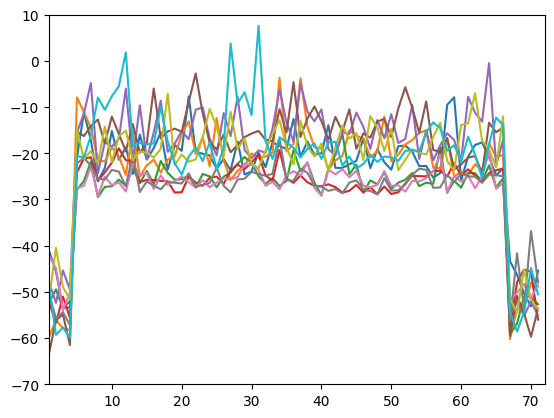

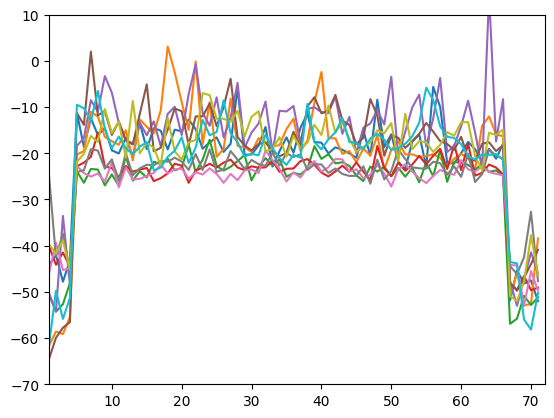

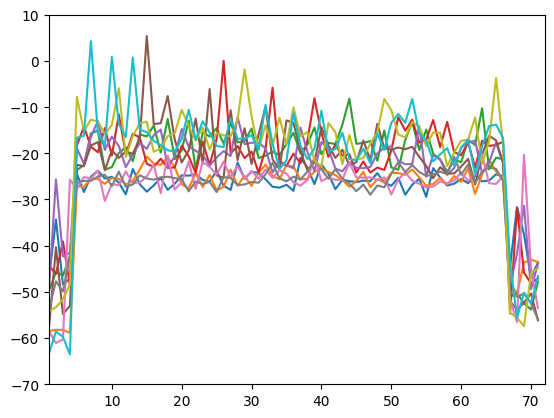

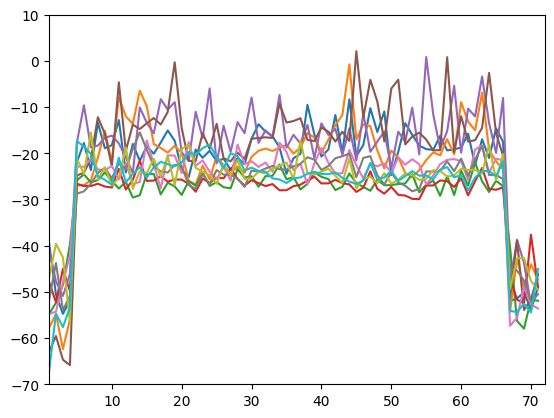

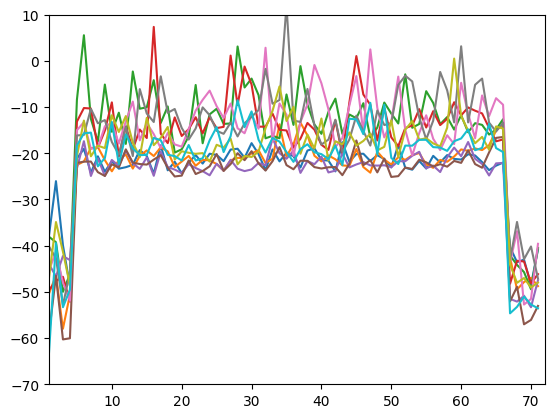

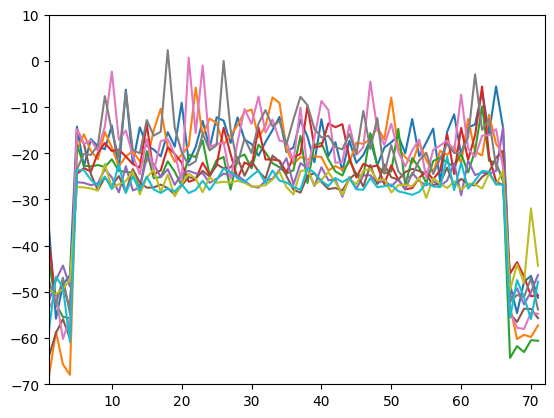

In [177]:
counter = 0

for single_file_name in all_files_received:
    single_file = np.load(os.path.join(data_path, key_world, single_file_name))
    channel_estimation = estimate_channels(single_file, pss_sss_raw)
    
    
    channel_estimation = np.abs(channel_estimation)
    channel_estimation = to_log(channel_estimation)
    

    freqs_pss = range(72)
    plt.figure()
    plt.plot(freqs_pss, channel_estimation[:,:10])
    plt.xlim([1,72])
    plt.ylim([-70,10])
    
    counter += 1
    
    if counter >5:
    
    
        break

In [60]:
def to_log(values: np.array) -> np.array:
    return 20 * np.log10(values)

In [61]:
def mean_channel_by_seq(signal: np.array, n_channels: int = 1):
    n_signals = (signal.shape[1]//2)//n_channels

    all_signals = np.array([])
    
    for x in range(n_signals):
        single_signal_sss = signal[:, range((n_channels*2*x),(n_channels*2*(x+1)),2)]
        single_signal_pss = signal[:, range((n_channels*2*x) + 1,(n_channels*2*(x+1)),2)]

        mean_sss = np.expand_dims(np.mean(single_signal_sss, axis=1), axis=1)
        mean_pss = np.expand_dims(np.mean(single_signal_pss, axis=1), axis=1)
        cnt = np.concatenate((mean_sss, mean_pss), axis=1)

        if len(all_signals) == 0:
            all_signals = cnt
        else:
            all_signals = np.concatenate((all_signals, cnt), axis=1)

    return np.asarray(all_signals)

In [62]:
def get_cross_corelation(signal_a: np.array, signal_b: np.array):
    return np.correlate(signal_a, signal_a, mode='full')

In [63]:
def estimate_channels(signal, original_sequence):
    multiply = signal.shape[1]//4
    new_seq = np.repeat(original_sequence, multiply, axis=1)

    if not signal.shape[1]%4 == 0:
        new_seq = np.concatenate((new_seq, original_sequence[:,:2]), axis=1)

    return new_seq/signal

In [64]:
full_path_received = os.path.join(paths[key_world], all_files_received[2])
mat_file_received = np.load(full_path_received)

In [65]:
new_channel = estimate_channels(mat_file_received, pss_sss_raw)
#new_channel = mean_channel_by_seq(new_channel)

In [66]:
h_abs = new_channel
h_abs = np.abs(h_abs)
h_abs = mean_channel_by_seq(h_abs, n_channels = mean_vals)
#h_abs = to_log(h_abs)



#h_abs = to_log(h_abs)